In [3]:
import pandas as pd

import geopandas as gpd
from shapely.geometry import Polygon

from ast import literal_eval

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [4]:
user_data = pd.read_csv('Users-08-12.csv')
annotations = pd.read_csv('Annotations-08-12.csv')

In [3]:
# takes 6 minutes

roads_basemap = gpd.read_file('gis_osm_roads_free_1.shp')
landuse_basemap = gpd.read_file('gis_osm_landuse_a_free_1.shp')

In [4]:
# takes 1 minute

water_basemap = gpd.read_file('gis_osm_water_a_free_1.shp')
waterways_basemap = gpd.read_file('gis_osm_waterways_free_1.shp')

# Mapping Annotations
- add basemap
- colour based on category - Spectral
- colour based on reactions - Coolwarm

In [33]:
gdf = gpd.GeoDataFrame(
    annotations, geometry=gpd.points_from_xy(annotations.long, annotations.lat), crs="EPSG:4326")
gdf.head(5)

,id,original,lat,long,rating,comment,category,user_id,geometry
0,cd993bb0-9609-44db-8861-4f95eea51bb2,1,55.702910,12.540513,4.0,Football fields are nice as there is always li...,"['Recreation/Leisure', 'Exercise/Fitness']",4722b64c-cf3d-4dc6-8dcc-cf82950b5b79,POINT (12.54051 55.70291)
1,c687c4e7-b0ad-40bb-b5e8-4d8c73e0dd8a,1,55.703854,12.538563,5.0,Shopping centre close to home is very handy fo...,['Convenience Stores'],4722b64c-cf3d-4dc6-8dcc-cf82950b5b79,POINT (12.53856 55.70385)
2,c51b24e8-2f50-4eae-a108-cc4683eb1f73,1,55.701252,12.538190,5.0,Big supermarket nearby with everything you nee...,"['Groceries', 'Convenience Stores']",4722b64c-cf3d-4dc6-8dcc-cf82950b5b79,POINT (12.53819 55.70125)
3,8974fabc-4812-4800-8d03-7f904b45e9aa,1,55.853054,12.563505,5.0,I use the train station every day to get into ...,['Transportation'],bf5c0f07-76e6-405a-8a60-52a93c19f48b,POINT (12.56350 55.85305)
4,a09bcd4e-6b63-408c-bf31-aad9d3dae287,1,55.700910,12.538532,5.0,Metro and s-train nearby is also super conveni...,['Transportation'],4722b64c-cf3d-4dc6-8dcc-cf82950b5b79,POINT (12.53853 55.70091)


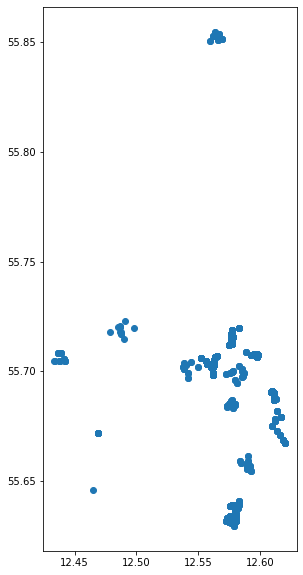

In [6]:
ax = gdf.plot(figsize=(10, 10))

-> I decided to remove Vedbaek to make my map more focused.

## Mapping ratings

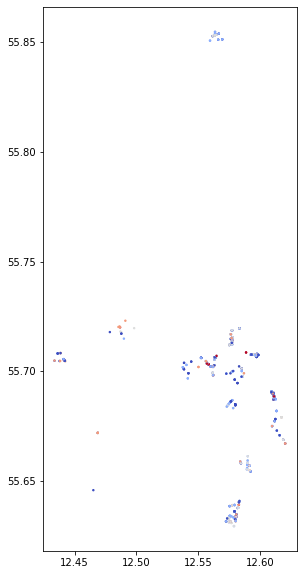

In [7]:
gdf.plot(figsize=(10, 10), column=gdf.rating, cmap='coolwarm_r', s=2);

## Is it in a park?
- identify polygons of parks
- check if data is in polygon

In [8]:
len(landuse_basemap)

500981

In [9]:
landuse_basemap['fclass'].unique()

array(['park', 'cemetery', 'meadow', 'nature_reserve', 'grass',
       'military', 'recreation_ground', 'residential', 'forest',
       'industrial', 'commercial', 'farmyard', 'allotments', 'farmland',
       'retail', 'quarry', 'scrub', 'heath', 'vineyard', 'orchard'],
      dtype=object)

In [10]:
parks_basemap = landuse_basemap[landuse_basemap.fclass.isin(['forest', 'park', 'cemetery', 'allotments', 'meadow', 'nature_reserve', 'recreation_ground'])]

In [11]:
# Removing unnecessary parks and green areas.
my_map_vertices = [(12.4, 55.5), (12.7, 55.5), (12.7, 55.9), (12.4, 55.9)]
my_map_polygon = Polygon(my_map_vertices)

# Takes ca. 5 minutes
my_parks_basemap = gpd.GeoDataFrame(columns=parks_basemap.columns)
for index, row in parks_basemap.iterrows():
    if row['geometry'].intersects(my_map_polygon):
        my_parks_basemap = my_parks_basemap.append(row, ignore_index=True)

In [12]:
len(parks_basemap)

198512

In [13]:
len(my_parks_basemap)

4658

In [14]:
gdf['green_area'] = gdf.apply(lambda point: any(point.geometry.within(poly) for poly in my_parks_basemap['geometry']), axis=1)

In [15]:
df = pd.DataFrame(gdf)
df.to_csv('df.csv')

# Visualisation: parks, roads, water
- add oceans / coastline: check https://www.opendata.dk/city-of-copenhagen/oversigtskort

In [16]:
roads_basemap = roads_basemap[roads_basemap.fclass.isin(['motorway', 'trunk', 'primary', 'secondary', 'tertiary'])] # potentially add 'residential'

In [17]:
roads_basemap.to_file('roads_basemap.geojson', driver='GeoJSON')

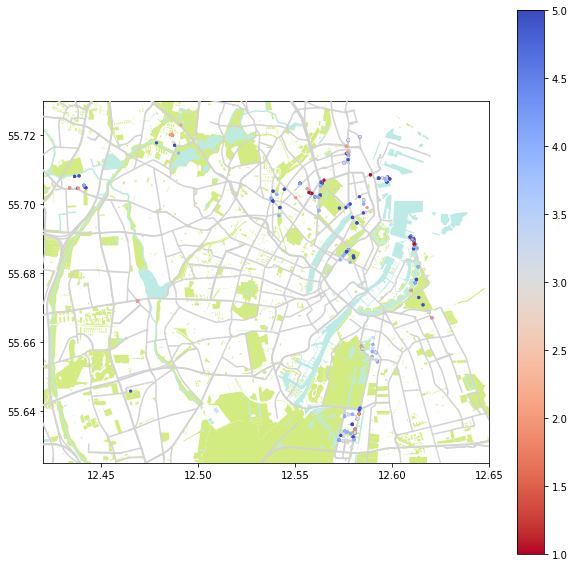

In [18]:
# takes ca. 2 minutes

fig, ax = plt.subplots(figsize=(10, 10))
my_parks_basemap.plot(ax=ax, color='#D3EC81', zorder=0)
water_basemap.plot(ax=ax, color='#BCEBE6', zorder=1)
waterways_basemap.plot(ax=ax, color='#BCEBE6', zorder=2)
roads_basemap.plot(ax=ax, color='#D3D3D3', zorder=3)
gdf.plot(ax=ax, column=gdf.rating, cmap='coolwarm_r', legend=True, s=5, zorder=4)
ax.set_xlim(12.42, 12.65)
ax.set_ylim(55.625, 55.73)

plt.savefig('ratings_map.png')
plt.show()

NameError: name 'my_parks_basemap' is not defined

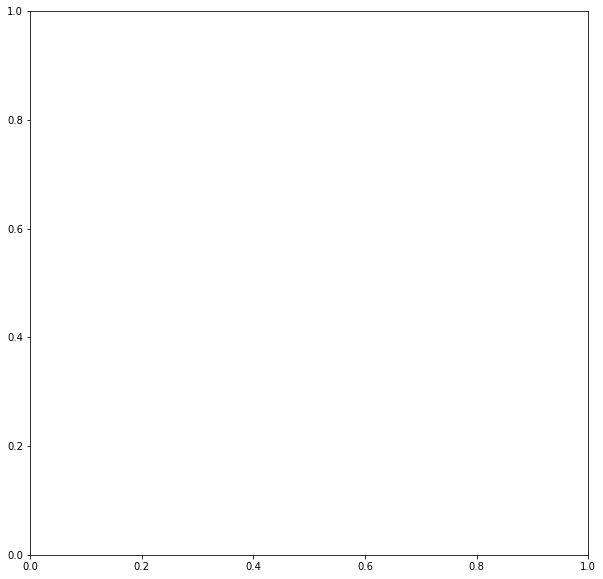

In [48]:
# takes ca. 2 minutes

fig, ax = plt.subplots(figsize=(10, 10))
my_parks_basemap.plot(ax=ax, color='#D3EC81', zorder=0)
water_basemap.plot(ax=ax, color='#BCEBE6', zorder=1)
waterways_basemap.plot(ax=ax, color='#BCEBE6', zorder=2)
roads_basemap.plot(ax=ax, color='#D3D3D3', zorder=3)
gdf_exploded.plot(ax=ax, column=gdf_exploded.category, cmap='Spectral', legend=True, s=5, zorder=4)
ax.set_xlim(12.42, 12.65)
ax.set_ylim(55.625, 55.73)

plt.savefig('categories_map.png')
plt.show()

Zooming into Osterbro & Nordhavn

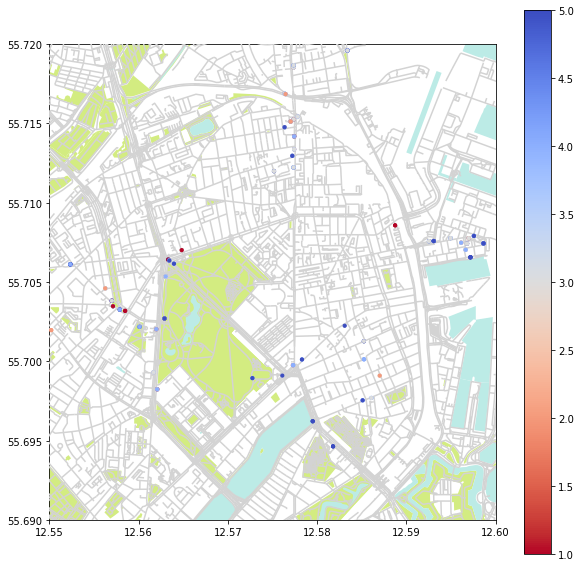

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
my_parks_basemap.plot(ax=ax, color='#D3EC81', zorder=0)
water_basemap.plot(ax=ax, color='#BCEBE6', zorder=1)
waterways_basemap.plot(ax=ax, color='#BCEBE6', zorder=2)
roads_basemap.plot(ax=ax, color='#D3D3D3', zorder=3)
gdf.plot(ax=ax, column=gdf.rating, cmap='coolwarm_r', legend=True, s=10, zorder=4)
ax.set_xlim(12.55, 12.60)
ax.set_ylim(55.69, 55.72)

plt.savefig('ratings_osterbro_map.png')
plt.show()

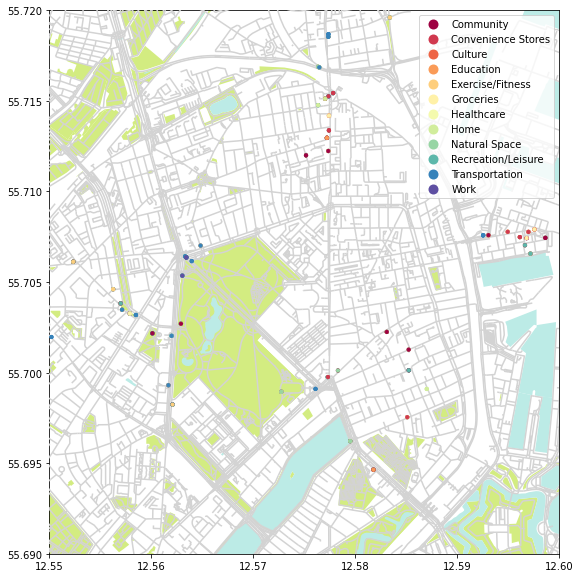

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
my_parks_basemap.plot(ax=ax, color='#D3EC81', zorder=0)
water_basemap.plot(ax=ax, color='#BCEBE6', zorder=1)
waterways_basemap.plot(ax=ax, color='#BCEBE6', zorder=2)
roads_basemap.plot(ax=ax, color='#D3D3D3', zorder=3)
gdf_exploded.plot(ax=ax, column=gdf_exploded.category, cmap='Spectral', legend=True, s=10, zorder=4)
ax.set_xlim(12.55, 12.60)
ax.set_ylim(55.69, 55.72)

plt.savefig('categories_osterbro_map.png')
plt.show()

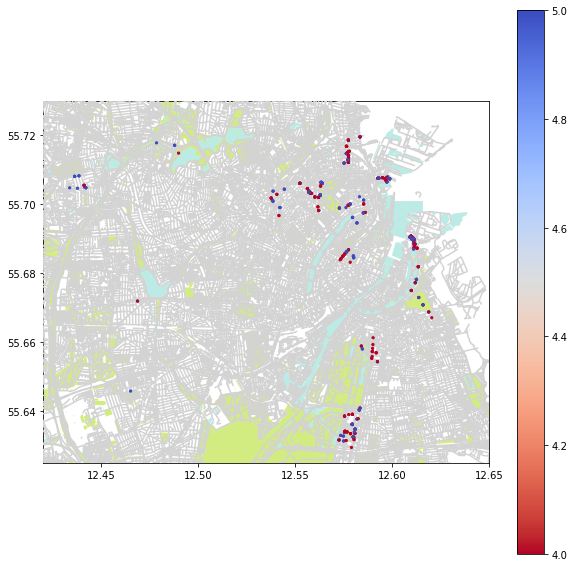

In [ ]:
# positive ratings
temp = gdf[(gdf.rating == 4)|(gdf.rating == 5)]

# takes ca. 2 minutes

fig, ax = plt.subplots(figsize=(10, 10))
my_parks_basemap.plot(ax=ax, color='#D3EC81', zorder=0)
water_basemap.plot(ax=ax, color='#BCEBE6', zorder=1)
waterways_basemap.plot(ax=ax, color='#BCEBE6', zorder=2)
roads_basemap.plot(ax=ax, color='#D3D3D3', zorder=3)
temp.plot(ax=ax, column=temp.rating, cmap='coolwarm_r', legend=True, s=5, zorder=4)
ax.set_xlim(12.42, 12.65)
ax.set_ylim(55.625, 55.73)

plt.savefig('ratings_map_4-5.png')
plt.show()

# Visualising ratings
- based on the category they added

In [22]:
# Exploding categories
def safe_literal_eval(value):
    try:
        return literal_eval(value)
    except (SyntaxError, ValueError):
        return value

gdf['category'] = gdf['category'].apply(safe_literal_eval)
gdf_exploded = gdf.explode('category')

In [21]:
gdf_green_area = gdf[gdf.green_area == True]

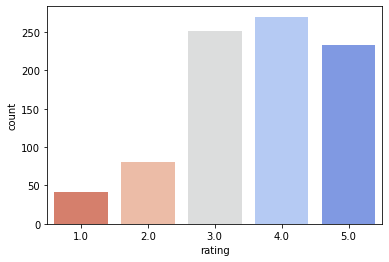

In [22]:
sns.countplot(x=gdf.rating, palette='coolwarm_r')
plt.savefig('rating_overall_09-12.png')
plt.show()

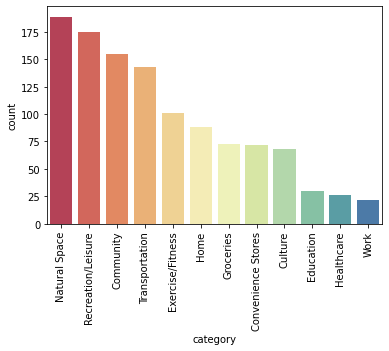

In [23]:
sns.countplot(x=gdf_exploded.category, order=gdf_exploded.category.value_counts().index, palette='Spectral')
plt.xticks(rotation=90)
plt.savefig('count_categories_09-12.png')
plt.show()

In [43]:
gdf_exploded['percent'] = gdf_exploded.groupby(['category', 'rating'])['rating'].transform('count') / gdf_exploded.groupby('category')['rating'].transform('count') * 100

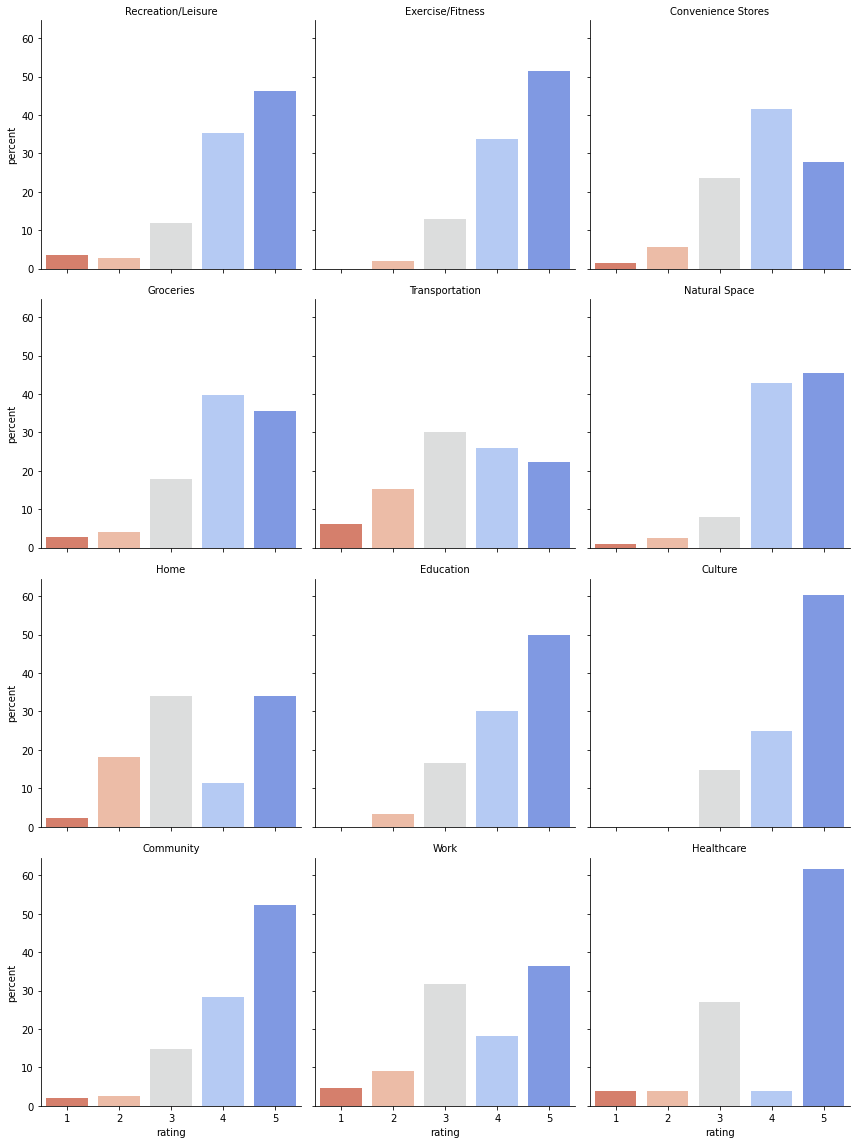

In [48]:
g = sns.FacetGrid(gdf_exploded, col='category', col_wrap=3, height=4, sharey=True)

# Map the countplot onto the grid
g.map(sns.barplot, 'rating', 'percent', order=[1, 2, 3, 4, 5], palette='coolwarm_r')

# Customize plot
g.set_titles(col_template="{col_name}")

# Show the plot
plt.savefig('percent-rating-per-category_10-01.png')
plt.show()

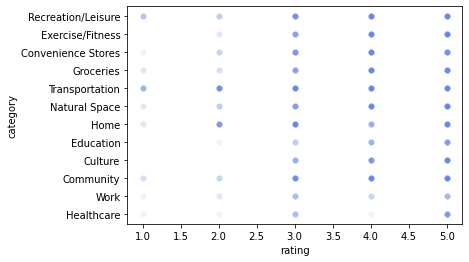

In [25]:
sns.scatterplot(data=gdf_exploded, x='rating', y='category', alpha=0.1, color="#6788ee")
plt.savefig('rating_per-category_12-12.png')

In [26]:
# idea: boxplot mean and sd
category_deviation = gdf_exploded.groupby('category')['rating'].mean()

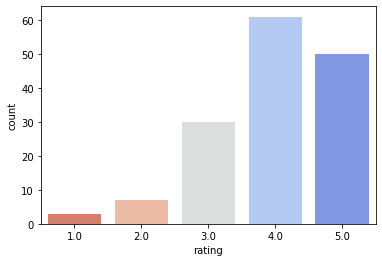

In [27]:
sns.countplot(x=gdf_green_area.rating, palette='coolwarm_r')
plt.savefig('rating_green-area_09-12.png')
plt.show()

# Compare category relations to green areas

In [28]:
len(gdf[gdf.green_area == True])

155

In [29]:
len(gdf_exploded[gdf_exploded.green_area == True])

268

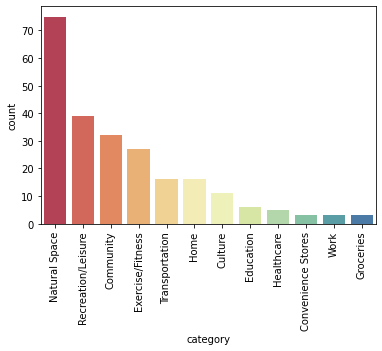

In [30]:
sns.countplot(x=gdf_exploded.category[gdf_exploded.green_area == True], order=gdf_exploded.category[gdf_exploded.green_area == True].value_counts().index, palette='Spectral')
plt.xticks(rotation=90)
plt.savefig('count_green_area_categories_11-12.png')
plt.show()

- bring in concrete example images

# Category matrix

In [49]:
# Keep the rows where a category is added
gdf_cleaned = gdf.dropna(subset=['category'])

In [50]:
# Extract unique categories
gdf_cleaned['category'] = gdf_cleaned['category'].apply(eval)
unique_categories = set(category for categories in gdf_cleaned['category'] for category in categories)

In [51]:
# Create a binary matrix
binary_matrix = pd.DataFrame(0, index=gdf_cleaned.index, columns=unique_categories)

for index, row in gdf_cleaned.iterrows():
    for category in row['category']:
        binary_matrix.at[index, category] = 1

# Remove columns with all zeros
binary_matrix = binary_matrix.loc[:, (binary_matrix != 0).any(axis=0)]

# Concatenate the binary matrix DataFrame with the original DataFrame
gdf_encoded = pd.concat([gdf_cleaned, binary_matrix], axis=1)

In [52]:
# Calculate the co-occurrence matrix
co_occurrence_matrix = binary_matrix.T.dot(binary_matrix)

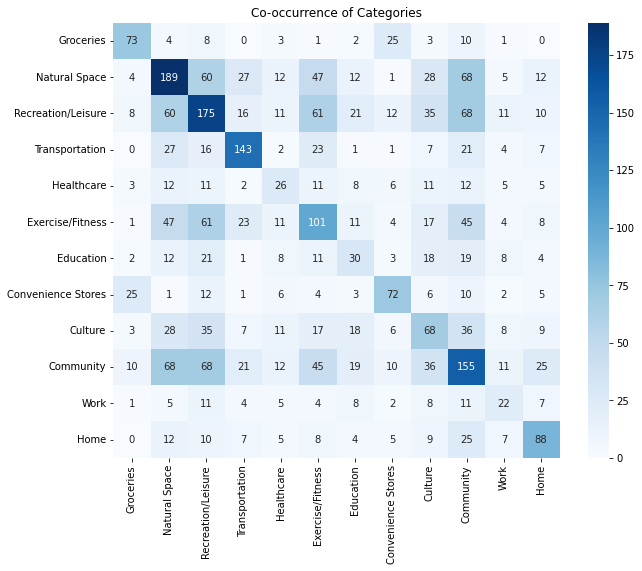

In [53]:
# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(co_occurrence_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=binary_matrix.columns, yticklabels=binary_matrix.columns)
plt.title('Co-occurrence of Categories')
plt.savefig('category_co-occurrence.png')
plt.show()